In [1]:
%load_ext dotenv
%reload_ext dotenv
%dotenv

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.feature_selection import f_regression

In [4]:
import sys
import os
from os.path import dirname

UTILS_PATH=os.environ.get('REPO') + "/notebooks/commons"
sys.path.append(dirname(UTILS_PATH))

from commons import check_args, gen_paths, coordinates_bounds, plot_feature_importances

In [5]:
def load_posts(input_path):
    df = pd.read_parquet(input_path)
    return df

In [6]:
if __name__ == "__main__":
    city = "manizales"
    property_type = "apartamentos"
    post_type = "arriendo"
    
    #city, property_type, post_type = check_args()
    base_path = os.environ.get('REPO')

    raw_path, clean_path = gen_paths(city, property_type, post_type)
    
    raw_path = base_path + raw_path
    clean_path = base_path + clean_path

In [7]:
MSG = """
Hay {} publicaciones de {} en total
"""

posts = load_posts(clean_path)
print(MSG.format(posts.shape[0], post_type))
posts.head()


Hay 1027 publicaciones de arriendo en total



,surface,rooms,baths,garages,price,latitude,description,longitude,location,url,admon,estrato,antiguedad,fid,city,property_type,post_type,price_m2
0,65.0,2.0,1.0,0.0,0.65,5.058869,Arrienda apartamento en el barrio La Sultana s...,-75.475807,Manizales La Sultana,https://www.fincaraiz.com.co/apartamento-en-ar...,0.0,4.0,desconocido,5469476,manizales,apartamentos,arriendo,0.010000
1,55.0,2.0,1.0,0.0,0.80,5.058840,Apartamento con excelente iluminación muy bien...,-75.485168,Manizales La Rambla,https://www.fincaraiz.com.co/apartamento-en-ar...,0.0,5.0,1 a 8,5357660,manizales,apartamentos,arriendo,0.014545
2,80.0,2.0,2.0,1.0,1.90,5.052409,Administra Bienes Raíces ofrece para arrendami...,-75.485085,Manizales Camelia,https://www.fincaraiz.com.co/apartamento-en-ar...,0.0,6.0,1 a 8,5670358,manizales,apartamentos,arriendo,0.023750
4,100.0,4.0,2.0,0.0,1.25,5.053482,Espacioso apartamento en un tercer piso con gr...,-75.495567,Manizales Fátima,https://www.fincaraiz.com.co/apartamento-en-ar...,0.0,3.0,1 a 8,5468657,manizales,apartamentos,arriendo,0.012500
5,41.0,3.0,1.0,0.0,0.50,5.070275,"Area de 41 mtrs, excelente ubicacion, muy ilum...",-75.513817,Manizales SANTOS,https://www.fincaraiz.com.co/apartamento-en-ar...,0.0,3.0,16 a 30,5174681,manizales,apartamentos,arriendo,0.012195


## Es necesario cambiar la representación de algunas de las columnas


In [8]:
## La antiguedad tiene 5 posibles valores pero se representa con un string, la idea es usar un entero en cambio

antiguedades = posts["antiguedad"].value_counts().index
new_antiguedades = {}
for i in range(len(antiguedades)):
    new_antiguedades[antiguedades[i]] = i
new_antiguedades

{'desconocido': 0, '9 a 15': 1, '1 a 8': 2, '16 a 30': 3, 'Más de 30': 4}

In [9]:
posts.loc[:, "antiguedad"] = posts["antiguedad"].apply(lambda e: new_antiguedades[e])

In [10]:
## Las features y las etiquetas son las mismas en todos los métodos

FEATURES = [
    'surface', 'rooms', 
    'baths', 'garages', 'latitude', 
    'longitude', 'admon', 
    'estrato','antiguedad'
]

LABEL = "price"

X = posts[FEATURES].values
y = posts[LABEL].values

## Selección de features univariada

In [11]:
selector = SelectKBest(f_regression, k=5)
X_new = selector.fit_transform(X, y)
X_new.shape

(1027, 5)

In [12]:
feature_importances = pd.DataFrame({'importance': selector.scores_, 'feature': FEATURES})

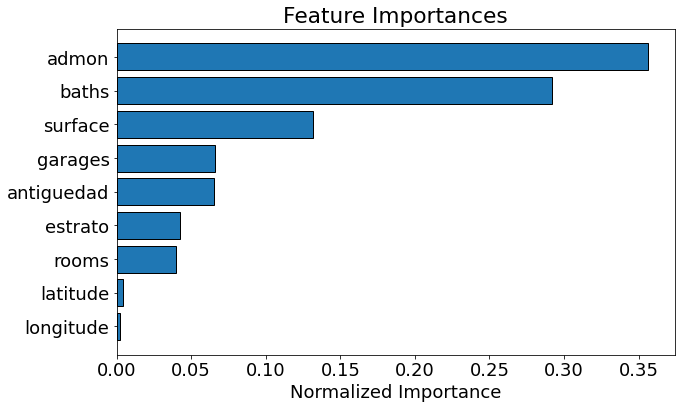

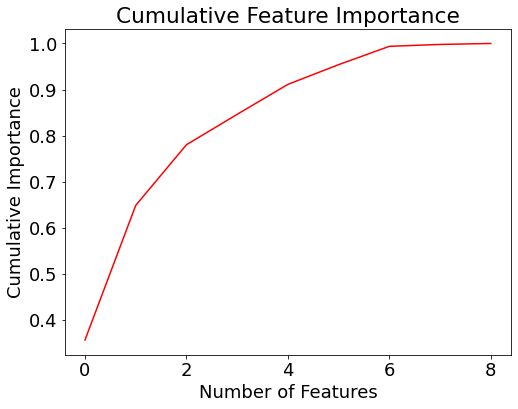

5 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,6,7.683912,admon,0.356260,0.356260
1,2,6.301895,baths,0.292184,0.648444
2,0,2.840452,surface,0.131696,0.780141
3,3,1.423705,garages,0.066009,0.846150
4,8,1.402973,antiguedad,0.065048,0.911198
5,7,0.923594,estrato,0.042822,0.954020
6,1,0.857235,rooms,0.039745,0.993765
7,4,0.089377,latitude,0.004144,0.997909
8,5,0.045098,longitude,0.002091,1.000000


In [13]:
plot_feature_importances(feature_importances)

## Eliminación recursiva de features

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [15]:
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.014994790661564172

In [16]:
rfe = RFE(estimator=reg, n_features_to_select=1, step=1)
rfe.fit(X, y)

RFE(estimator=LinearRegression(), n_features_to_select=1)

In [17]:
feature_importances = pd.DataFrame({'importance': rfe.ranking_, 'feature': FEATURES})

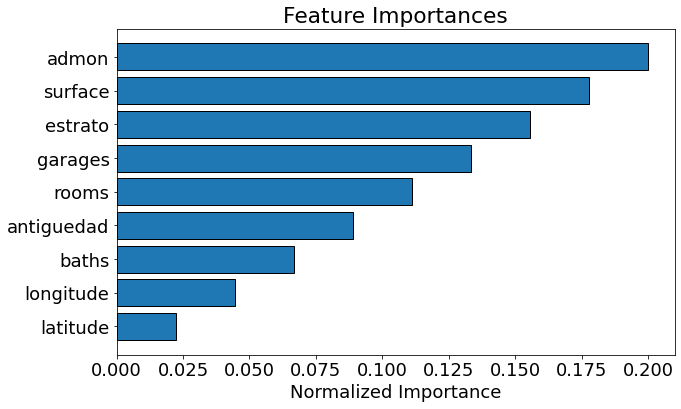

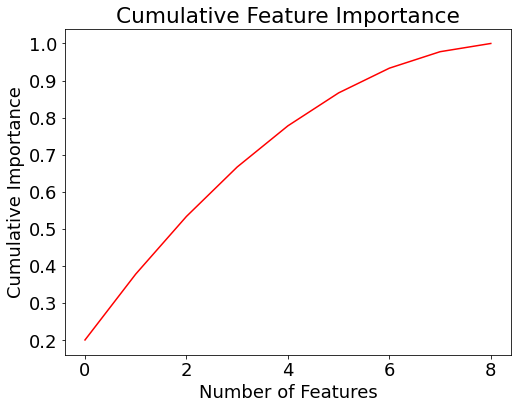

7 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,6,9,admon,0.200000,0.200000
1,0,8,surface,0.177778,0.377778
2,7,7,estrato,0.155556,0.533333
3,3,6,garages,0.133333,0.666667
4,1,5,rooms,0.111111,0.777778
5,8,4,antiguedad,0.088889,0.866667
6,2,3,baths,0.066667,0.933333
7,5,2,longitude,0.044444,0.977778
8,4,1,latitude,0.022222,1.000000


In [18]:
plot_feature_importances(feature_importances)

## Selección de features basada en arboles

In [19]:
from sklearn.ensemble import ExtraTreesRegressor

In [20]:
forest = ExtraTreesRegressor(n_estimators=100, random_state=0)
forest.fit(X, y)

ExtraTreesRegressor(random_state=0)

In [21]:
feature_importances = pd.DataFrame({'importance':  forest.feature_importances_, 'feature': FEATURES})

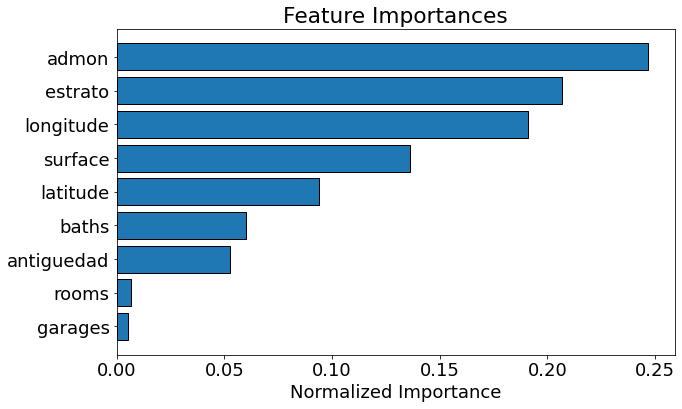

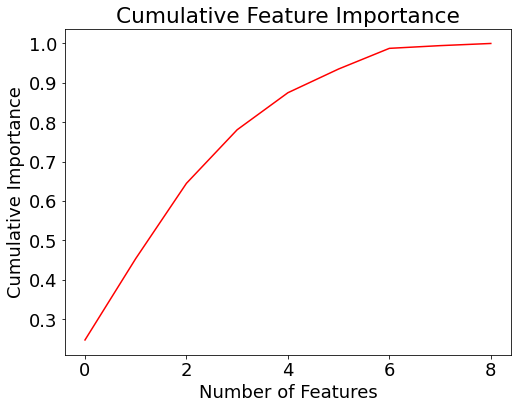

6 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,6,0.246703,admon,0.246703,0.246703
1,7,0.206760,estrato,0.206760,0.453463
2,5,0.191208,longitude,0.191208,0.644671
3,0,0.136111,surface,0.136111,0.780782
4,4,0.094068,latitude,0.094068,0.874850
5,2,0.060305,baths,0.060305,0.935155
6,8,0.052436,antiguedad,0.052436,0.987591
7,1,0.006892,rooms,0.006892,0.994483
8,3,0.005517,garages,0.005517,1.000000


In [22]:
plot_feature_importances(feature_importances)